<a href="https://colab.research.google.com/github/valcsuremm/GU-5423/blob/main/Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
!pip install "cellpose==2.3.2"
!pip install torch torchvision torchaudio
!pip install omnipose

#Fix opencv error: ImportError: cannot import name '_registerMatType' from 'cv2.cv2'
!pip install "opencv-python-headless<4.3"
exit(0) #Restart Runtime to use newly installed numpy
#or may get the error: ValueError: numpy.ndarray size changed, may indicate binary incompatibility. Expected 88 from C header, got 80 from PyObject

#https://stackoverflow.com/questions/8924173/how-do-i-print-bold-text-in-python
BOLD = '\033[1m'
UNDERLINE = '\033[4m'
END = '\033[0m'



print("\n"+BOLD+UNDERLINE+"Restarting the RUNTIME. Wait till you see the green tick on the right top, next to RAM and Disk before proceeding."+END)


  Using cached omnipose-1.0.6.tar.gz (2.0 MB)
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 98.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 10.8 MB/s eta 0:00:00
  Created wheel for omnipose: filename=omnipose-1.0.6-py3-none-any.whl size=345104 sha256=83cd004ffdbc6cd127bc391aebbd89983879db1a7e3cdf6fb69e44d2766570f8
  Stored in directory: /root/.cache/pip/wheels/c1/c1/11/6b60ad9e07f9ac4c6678e493d585aa13c2bd85303c0fc86c99
Successfully built omnipose
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3070, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/p

### Imports

In [3]:
import numpy as np
import time, os, sys, random
from urllib.parse import urlparse
import skimage.io
import matplotlib.pyplot as plt
import matplotlib as mpl
!pip install cellpose
import cellpose
from cellpose import models,core
import cv2
import os
import random
from skimage.util import img_as_ubyte
from cellpose import plot

import torch
from urllib.parse import urlparse
import shutil
from cellpose.io import logger_setup

from tifffile import imwrite
from google.colab import drive

import pandas as pd
import skimage.measure
import skimage.exposure

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, classification_report
import skimage


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.2/215.2 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 72.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 MB 41.8 MB/s eta 0:00:00


In [ ]:
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300

print ("Downloading Models")

model_list = models.MODEL_NAMES

logger_setup()


#Check if colab notebook instance has GPU access
if core.use_gpu()==False:
  #Warnings from the ZeroCost StarDist notebook
  print(BOLD+UNDERLINE+'You do not have GPU access.'+END)
  print('Did you change your runtime ?')
  print('If the runtime setting is correct then Google did not allocate a GPU for your session')
  print('Expect slow performance. To access GPU try reconnecting later')
  use_GPU=False
else:
  print(BOLD+UNDERLINE+"You have access to the GPU."+END+"\nDetails are:")
  print("*************************************************")
  !nvidia-smi
  use_GPU=True

print("*************************************************")
print("Libraries imported and configured")


creating new log file
You have access to the GPU.
Details are:
*************************************************
Tue Nov  5 17:58:25 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0              25W /  70W |    105MiB / 15360MiB |      3%      Default |
|                                         |  

The images to be used for training and testing are under downsampled_data.

### Loading images

In [ ]:

# Define input directory and image format
Input_Directory = "/content/gdrive/MyDrive/P2/part2/Data/downsampled_data"  # Input directory
input_dir = os.path.join(Input_Directory, "")  # Adds separator to the end regardless if path has it or not

# Specify the image format, e.g., ".tif" or ".jpg". Leave blank to load all images.
image_format = ".tif"  # Use ".tif" for TIFF images, or set to "" to load all formats

# Save directory (use a writable location like /content instead of Google Drive)
save_dir = "/content/Masks"
if os.path.exists(save_dir):
    print("Existing Mask Directory found in writable location. Deleting it.")
    shutil.rmtree(save_dir)
os.makedirs(save_dir, exist_ok=True)

# Inform the user about the writable location
print(f"Mask files will be saved in writable location: {save_dir}")

# Load image files from the input directory
files = []
for r, d, f in os.walk(input_dir):
    for file in f:
        # Check if file has the specified image format
        if image_format:
            # Allow common extensions for tiff files
            if file.lower().endswith((image_format, '.tiff')):
                files.append(os.path.join(r, file))
        else:
            files.append(os.path.join(r, file))
    break  # only read the root directory

# Check if any files were loaded
if len(files) == 0:
    print(f"Number of images loaded: {len(files)}.")
    print("No image files found. Check if folder has images or verify the image format.")
else:
    print(f"Number of images loaded: {len(files)}.")


Mask files will be saved in writable location: /content/Masks
Number of images loaded: 2867.


The number of images loaded matches what we expext based on the Data Card file information.

I am adapting the code from above to work faster using cv2.imread.

Example Image:
r10c01f03_median_aggregated.tiff has 2 dimension(s)
500 images loaded...
1000 images loaded...
1500 images loaded...
2000 images loaded...
2500 images loaded...
Total number of images loaded: 2867


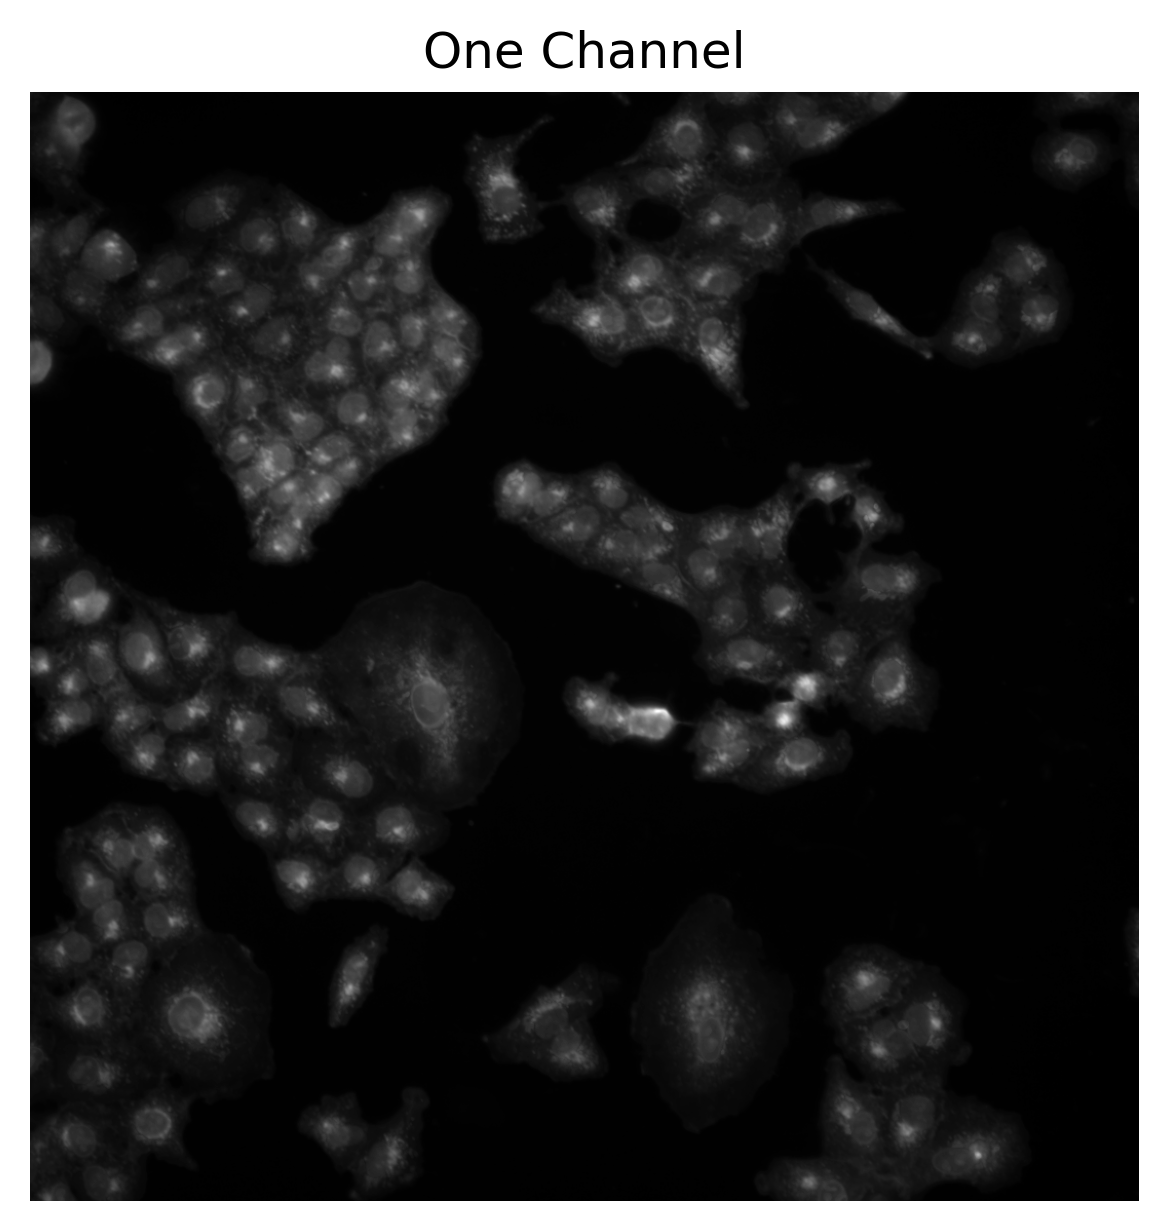

In [ ]:
#list of images
imgs = []  # Store all images

# Load images
for i, f in enumerate(files):
    im = cv2.imread(f, cv2.IMREAD_UNCHANGED)  #loading image using cv2

    # handling color channels BGR -> RGB
    if len(im.shape) == 3 and im.shape[2] == 3:
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)  # Convert to RGB for consistency

    # Appending to imgs
    imgs.append(im)

    # showing example
    if not example_image_loaded:
        example_image_loaded = True
        print("Example Image:")

        n_dim = len(im.shape)
        file_name = os.path.basename(f)
        print(f"{file_name} has {n_dim} dimension(s)")

        if n_dim == 3:
            channel_image = im.shape[2]
            fig, axs = plt.subplots(1, channel_image, figsize=(12, 5))
            print(f"Image: {file_name}")

            for channel in range(channel_image):
                axs[channel].imshow(im[:, :, channel], cmap='gray')
                axs[channel].set_title(f'Channel {channel+1}', size=15)
                axs[channel].axis('off')
            fig.tight_layout()
        elif n_dim == 2:
            plt.imshow(im, cmap='gray')
            plt.title("One Channel")
            plt.axis('off')
        else:
            print("Channel number invalid or dimensions wrong. Image shape is:", im.shape)

    # printed loading status
    if (i + 1) % 500 == 0:
        print(f"{i + 1} images loaded...")


nimg = len(imgs)
print(f"Total number of images loaded: {nimg}")


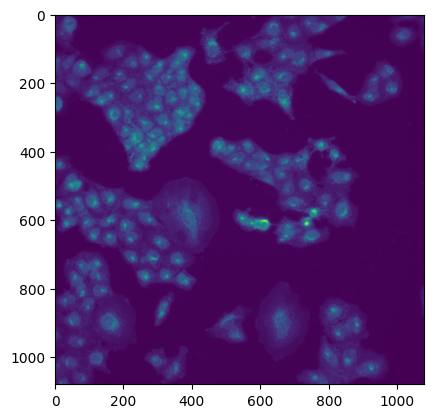

In [ ]:
plt.imshow(imgs[0])

### Segmentation

In [ ]:
print("Using cyto model")

Channel_for_segmentation=0
segment_channel=int(Channel_for_segmentation)

Use_nuclear_channel= False
Nuclear_channel=1
nuclear_channel=int(Nuclear_channel)


Diameter =  0 #diameter
diameter=Diameter

model_type="cyto"

if model_type != "nuclei":
  if Use_nuclear_channel:
    channels=[segment_channel,nuclear_channel]
  else:
    channels=[segment_channel,0]
else: #nucleus
  channels=[segment_channel,0]


# DEFINE CELLPOSE MODEL
use_GPU = torch.cuda.is_available()

# Define the Cellpose model with the correct parameters
model = models.CellposeModel(gpu=use_GPU, model_type="nuclei")


# define CHANNELS to run segementation on
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
# if NUCLEUS channel does not exist, set the second channel to 0
# channels = [0,0]
# IF ALL YOUR IMAGES ARE THE SAME TYPE, you can give a list with 2 elements
# channels = [0,0] # IF YOU HAVE GRAYSCALE
# channels = [2,3] # IF YOU HAVE G=cytoplasm and B=nucleus
# channels = [2,1] # IF YOU HAVE G=cytoplasm and R=nucleus

# or if you have different types of channels in each image
#channels = [[2,3], [0,0], [0,0]]

if diameter == 0:
  diameter = None
  print("Diameter is set to None. The size of the cells will be estimated on a per image basis")

Using cyto model


100%|██████████| 25.3M/25.3M [00:02<00:00, 9.40MB/s]
/usr/local/lib/python3.10/dist-packages/cellpose/resnet_torch.py:225: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  stat

Diameter is set to None. The size of the cells will be estimated on a per image basis


Image: r02c16f01_median_aggregated


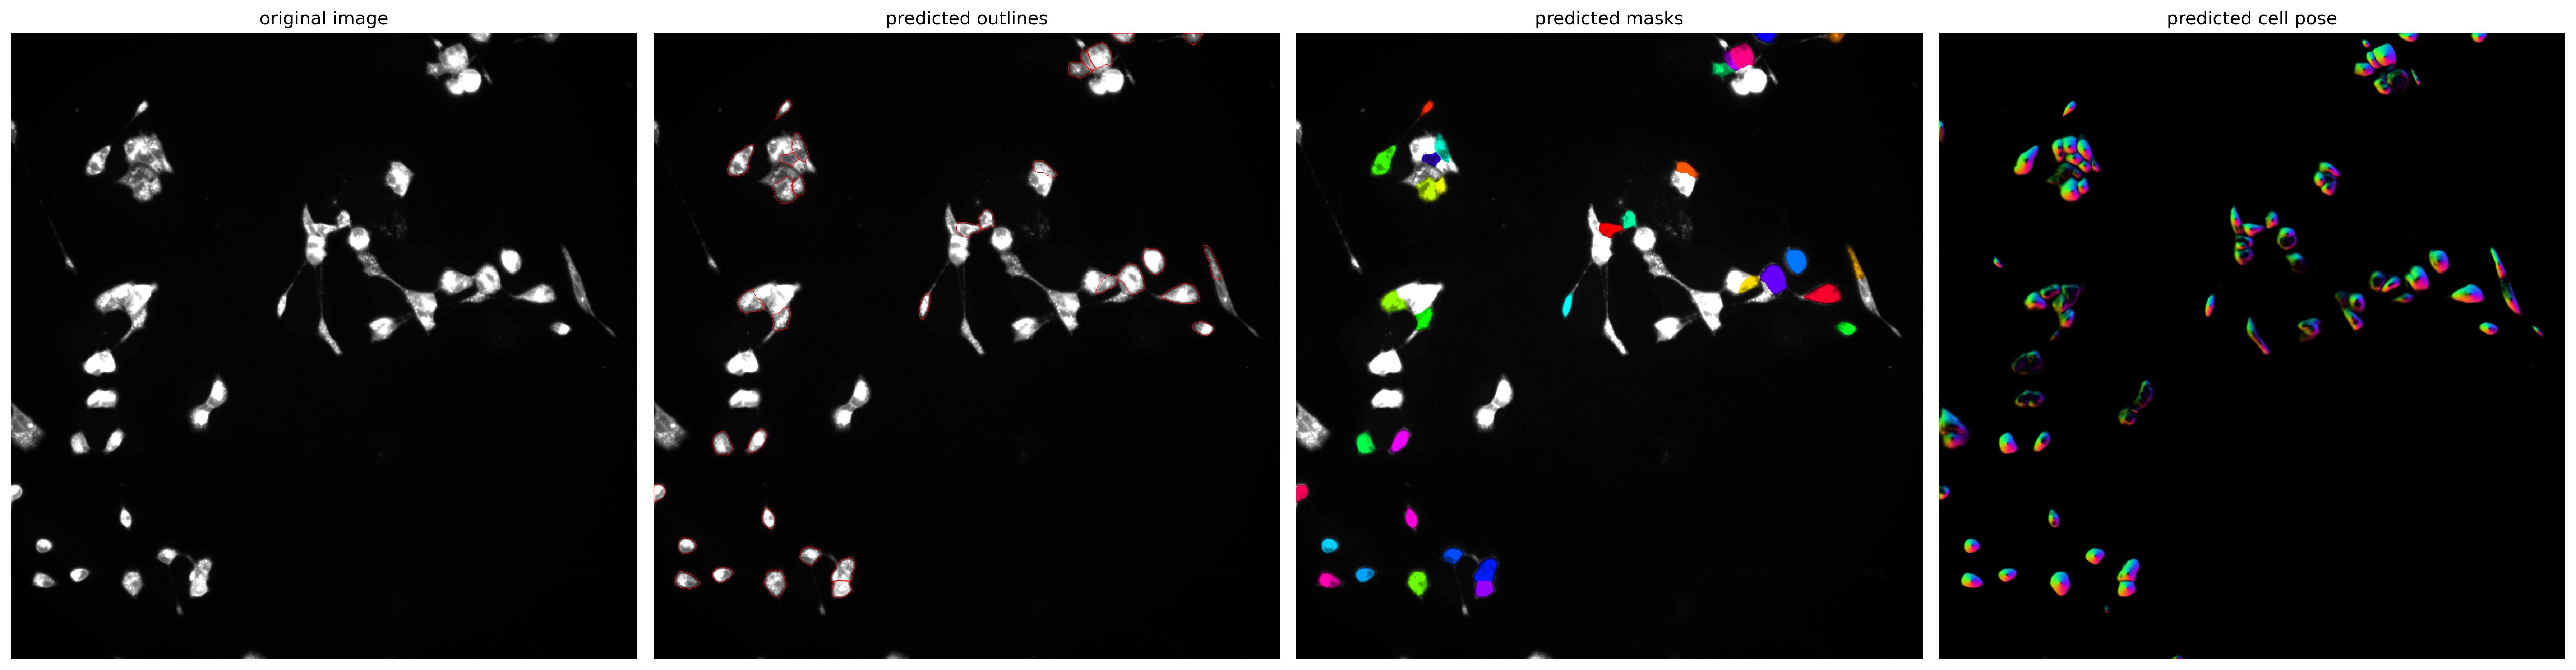

In [ ]:

Image_Number =  2
Image_Number-=1 #indexing starts at zero
#print(Image_Number)
Diameter = 0
Flow_Threshold = 0.5 #choosing flow threshold
flow_threshold=Flow_Threshold

Cell_Probability_Threshold=-5
cellprob_threshold=Cell_Probability_Threshold

diameter=Diameter
if diameter == 0:
  diameter = None
if Image_Number == -1:
  Image_Number=0
try:
    image = imgs[Image_Number]
except IndexError as i:
   print("Image number does not exist",i)
   print("Actual no of images in folder: ",len(imgs))
print("Image: %s" %(os.path.splitext(os.path.basename(files[Image_Number]))[0]))
img1=imgs[Image_Number]


masks, flows, styles = model.eval(img1, diameter=diameter, flow_threshold=flow_threshold,cellprob_threshold=cellprob_threshold, channels=channels)

# DISPLAY RESULTS
maski = masks
flowi = flows[0]

#convert to 8-bit if not so it can display properly in the graph
if img1.dtype!='uint8':
  img1=img_as_ubyte(img1)

fig = plt.figure(figsize=(24,8))
#if len(img1.shape)==3:
  #img_ch_plot = img1[:,:,segment_channel]img_ch_plot
plot.show_segmentation(fig, img1 , maski, flowi, channels=channels)
plt.tight_layout()
plt.show()

In [ ]:
imwrite('here.tif', mask.astype(np.uint16))

NameError: name 'mask' is not defined

In [ ]:
folder_path = '/content/gdrive/My Drive/Cellpose_Masks/' #mask folder path

# Check if the folder exists
if os.path.exists(folder_path):
    # List all files in the folder
    files_in_folder = os.listdir(folder_path)

    # Count the number of files and directories
    num_items = len(files_in_folder)

    print(f'Total number of items in the folder: {num_items}')
else:
    print("Folder does not exist. Please check the path.")


Total number of items in the folder: 2868


In [ ]:
save_dir = '/content/drive/My Drive/Cellpose_Masks/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Code for running segmentation
Save_Flow = False  # Change this to True if you want to save flow images
save_flow = Save_Flow

print("Running segmentation on channel %s" % (segment_channel))
print("Using the model: ", model_type)
if diameter is None:
    print("Diameter will be estimated from the image/s")
else:
    print(f"Cellpose will use a diameter of {diameter}")

print(f"Using a flow threshold of: {flow_threshold} and a cell probability threshold of: {cellprob_threshold}")

print("Segmentation Done. Saving Masks and flows now")
print("Save Directory is: ", save_dir)

if save_flow:
    flows_save_dir = save_dir + "flows" + os.sep
    print("Save Directory for flows is: ", flows_save_dir)
    if (not os.path.exists(flows_save_dir)):
        os.makedirs(flows_save_dir)

print(save_flow)
start = time.time()
for img_idx, img in enumerate(imgs):
    if img_idx % 20 == 0:
        print(f"Segmenting image {img_idx + 1} of {len(imgs)} at {time.time() - start}")
    file_name = os.path.splitext(os.path.basename(files[img_idx]))[0]

    # Run segmentation
    mask, flow, styles = model.eval(img, diameter=diameter, flow_threshold=flow_threshold,cellprob_threshold=cellprob_threshold, channels=channels)

    # Output name for masks
    mask_output_name = os.path.join(save_dir, f"MASK_{file_name}.png")

    # Save mask as 16-bit

    cv2.imwrite(mask_output_name, mask.astype(np.uint64))

# Save parameters used in Cellpose
parameters_file = os.path.join(save_dir, "Cellpose_parameters_used.txt")
with open(parameters_file, "w") as outFile:
    outFile.write("CELLPOSE PARAMETERS\n")
    outFile.write("Model: " + model_type + "\n")
    if diameter == 0:
        diameter = "Automatically estimated by cellpose"
    outFile.write("Diameter: " + str(diameter) + "\n")
    outFile.write("Flow Threshold: " + str(flow_threshold) + "\n")
    outFile.write("Cell probability Threshold: " + str(cellprob_threshold) + "\n")

print("\nSegmentation complete and files saved in Google Drive")


Mounted at /content/drive


NameError: name 'segment_channel' is not defined

In [ ]:
len(imgs)

2867

In [ ]:
save_dir = '/content/drive/My Drive/Cellpose_Masks/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

Save_Flow = False  #not saving flow images
save_flow = Save_Flow

print("Running segmentation on channel %s" % (segment_channel))
print("Using the model: ", model_type)
if diameter is None:
    print("Diameter will be estimated from the image/s")
else:
    print(f"Cellpose will use a diameter of {diameter}")

print(f"Using a flow threshold of: {flow_threshold} and a cell probability threshold of: {cellprob_threshold}")

print("Segmentation Done. Saving Masks and flows now")
print("Save Directory is: ", save_dir)

if save_flow:
    flows_save_dir = save_dir + "flows" + os.sep
    print("Save Directory for flows is: ", flows_save_dir)
    if (not os.path.exists(flows_save_dir)):
        os.makedirs(flows_save_dir)

print(save_flow)
start = time.time()

# Starting the loop from index 1943 to skip already-processed images
for img_idx in range(1943, len(imgs)):
    if img_idx % 20 == 0:
        print(f"Segmenting image {img_idx + 1} of {len(imgs)} at {time.time() - start}")
    file_name = os.path.splitext(os.path.basename(files[img_idx]))[0]

    mask, flow, styles = model.eval(imgs[img_idx], diameter=diameter, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold, channels=channels)

    mask_output_name = os.path.join(save_dir, f"MASK_{file_name}.png")

    # Save mask as 16-bit
    cv2.imwrite(mask_output_name, mask.astype(np.uint64))

# Save parameters used in Cellpose
parameters_file = os.path.join(save_dir, "Cellpose_parameters_used.txt")
with open(parameters_file, "w") as outFile:
    outFile.write("CELLPOSE PARAMETERS\n")
    outFile.write("Model: " + model_type + "\n")
    if diameter == 0:
        diameter = "Automatically estimated by cellpose"
    outFile.write("Diameter: " + str(diameter) + "\n")
    outFile.write("Flow Threshold: " + str(flow_threshold) + "\n")
    outFile.write("Cell probability Threshold: " + str(cellprob_threshold) + "\n")

print("\nSegmentation complete and files saved in Google Drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Running segmentation on channel 0
Using the model:  cyto
Diameter will be estimated from the image/s
Using a flow threshold of: 0.5 and a cell probability threshold of: -5
Segmentation Done. Saving Masks and flows now
Save Directory is:  /content/drive/My Drive/Cellpose_Masks/
False


/usr/local/lib/python3.10/dist-packages/cellpose/resnet_torch.py:225: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(filename, map_location=device)


Segmenting image 1961 of 2867 at 19.52201509475708
Segmenting image 1981 of 2867 at 42.44032049179077
Segmenting image 2001 of 2867 at 65.12664580345154
Segmenting image 2021 of 2867 at 88.24376273155212
Segmenting image 2041 of 2867 at 111.07880210876465
Segmenting image 2061 of 2867 at 133.63188314437866
Segmenting image 2081 of 2867 at 156.11761474609375
Segmenting image 2101 of 2867 at 179.09723329544067
Segmenting image 2121 of 2867 at 201.62489485740662
Segmenting image 2141 of 2867 at 223.96749639511108
Segmenting image 2161 of 2867 at 246.54127740859985
Segmenting image 2181 of 2867 at 269.0948543548584
Segmenting image 2201 of 2867 at 291.19810152053833
Segmenting image 2221 of 2867 at 313.89895510673523
Segmenting image 2241 of 2867 at 336.46121525764465
Segmenting image 2261 of 2867 at 359.7016975879669
Segmenting image 2281 of 2867 at 381.83263206481934
Segmenting image 2301 of 2867 at 404.2677671909332
Segmenting image 2321 of 2867 at 426.9800457954407
Segmenting image 234

### Metadata

In [ ]:
metadata_path = "/content/drive/MyDrive/P2/part2/Data/metadata_BR00116991.csv"  # Input directory

In [ ]:
masks_dir = '/content/gdrive/My Drive/Cellpose_Masks/'  #masks
images_dir = '/content/gdrive/MyDrive/P2/part2/Data/downsampled_data'  #corresponding images

### Feature extraction

In [ ]:
def extract_features(mask, image):
    regions = skimage.measure.regionprops(mask, intensity_image=image)

    features = []

    for region in regions:
        area = region.area
        perimeter = region.perimeter
        eccentricity = region.eccentricity
        solidity = region.solidity

        # intensity-based features
        mean_intensity = region.mean_intensity
        median_intensity = np.median(image[mask == region.label])
        std_intensity = np.std(image[mask == region.label])

        # storing features - 7 total
        features.append({
            'Area': area,
            'Perimeter': perimeter,
            'Eccentricity': eccentricity,
            'Solidity': solidity,
            'Mean Intensity': mean_intensity,
            'Median Intensity': median_intensity,
            'Standard Deviation Intensity': std_intensity
        })

    return features

In [ ]:
features_all_img = []

# Loop through each mask and image pair
for mask_file in os.listdir(masks_dir):
    if mask_file.endswith('.png'):
        mask_path = os.path.join(masks_dir, mask_file)
        image_file = mask_file.replace('MASK_', '').replace('.png', '.tiff')  # Adjust file naming
        image_path = os.path.join(images_dir, image_file)

        # loading mask and its image
        mask = skimage.io.imread(mask_path)
        image = skimage.io.imread(image_path)

        # features
        features = extract_features(mask, image)

        # Extract sample name from the image file name
        sample_name = image_file.split('_')[0]

        # sample name is in features list
        for feature in features:
            feature['sample_name'] = sample_name
            features_all_img.append(feature)

# the feature list to df
features_df = pd.DataFrame(features_all_img)

# saving features to CSV file
features_df.to_csv('/content/drive/My Drive/Cellpose_Features.csv', index=False)


ValueError: <COMPRESSION.LZW: 5> requires the 'imagecodecs' package

In [ ]:
features_df = pd.read_csv('/content/gdrive/My Drive/Cellpose_Features.csv')

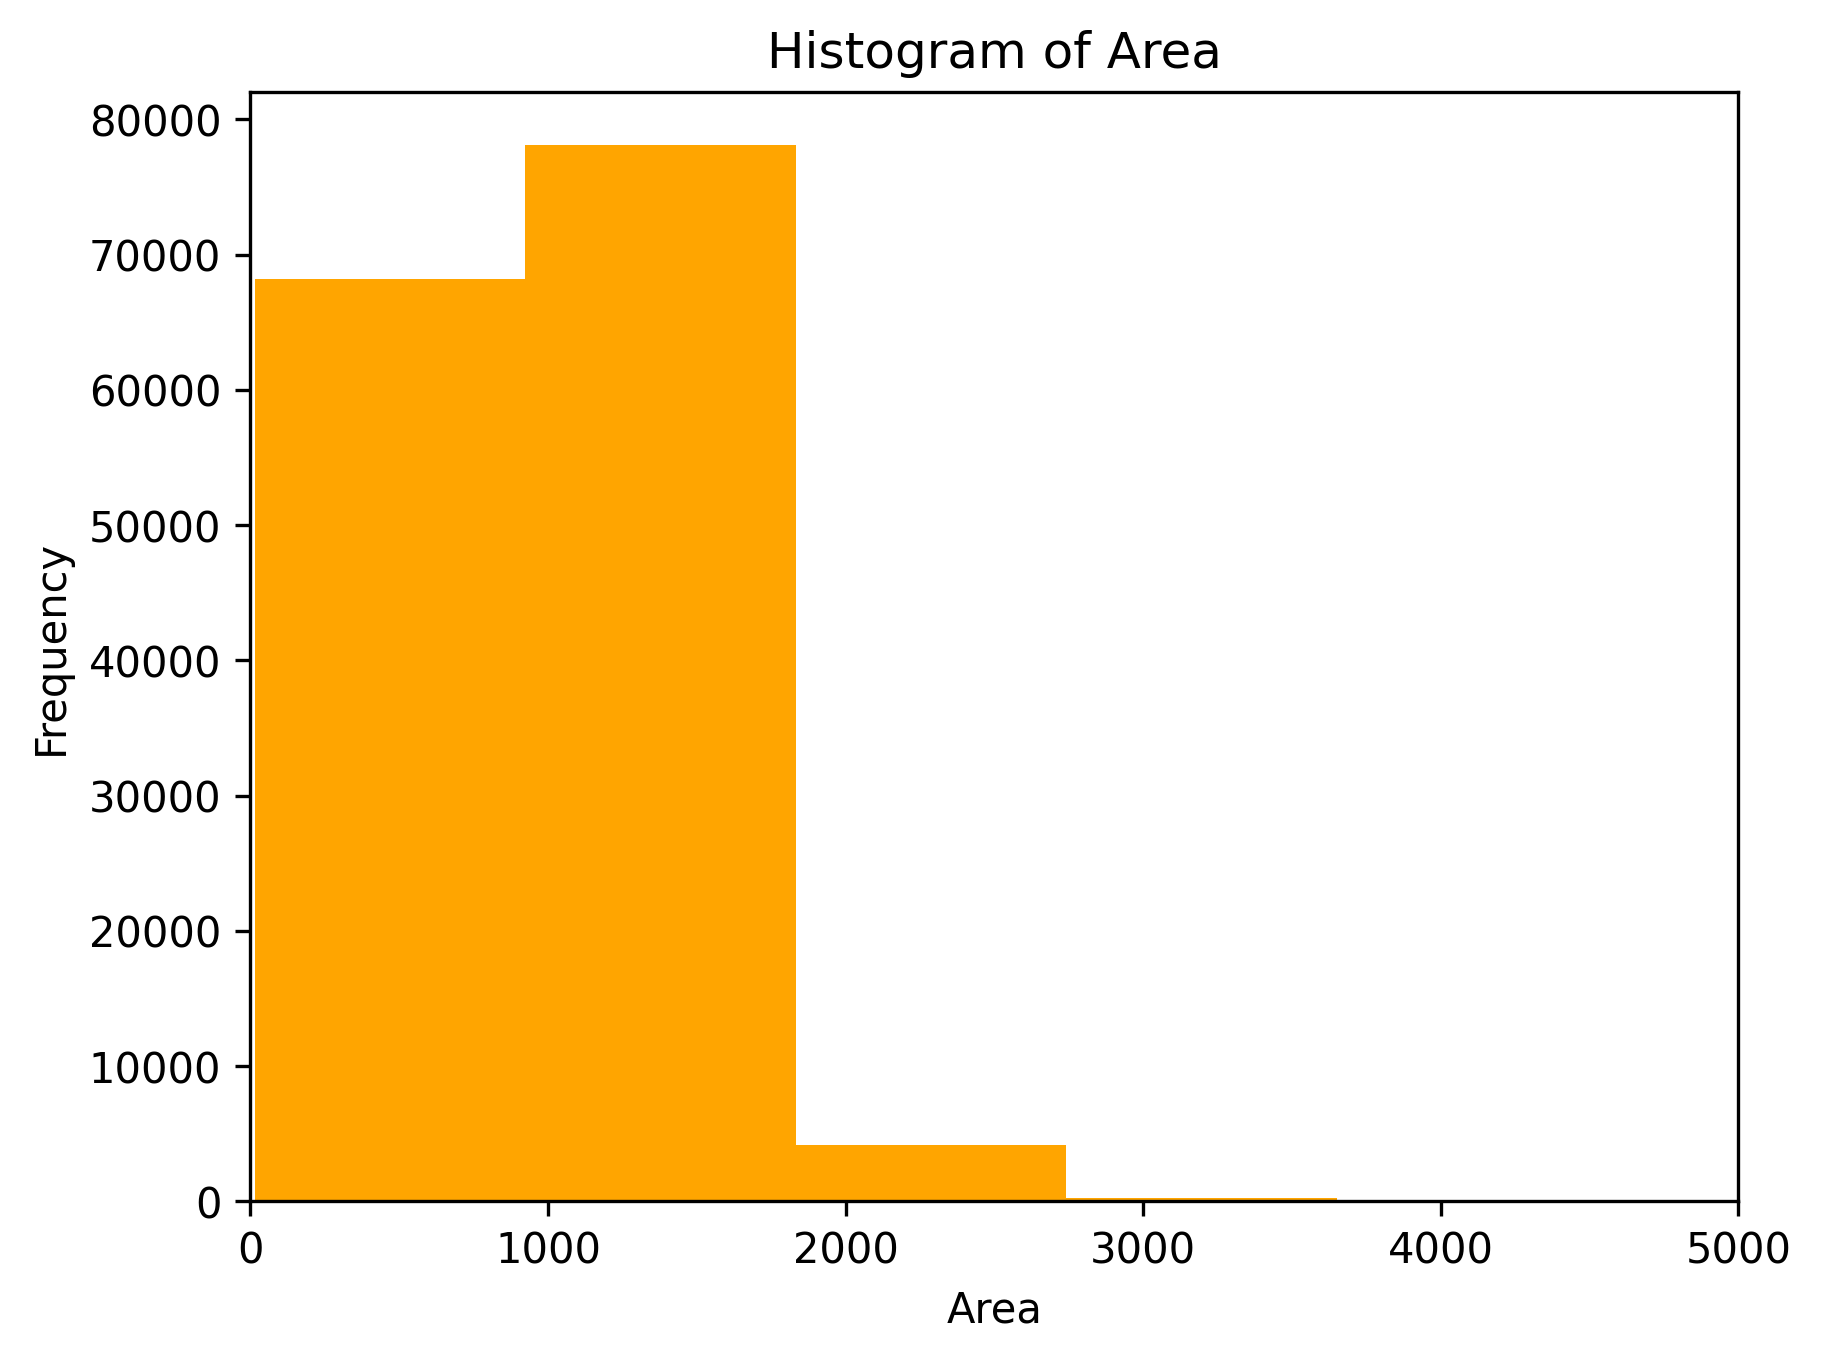

In [ ]:
feature_to_plot = 'Area'

plt.xlim(0, 5000)
plt.hist(features_df[feature_to_plot], color='orange', bins = 50)
plt.xlabel(feature_to_plot)
plt.title(f'Histogram of {feature_to_plot}')
plt.xlabel(feature_to_plot)
plt.ylabel('Frequency')

plt.show()


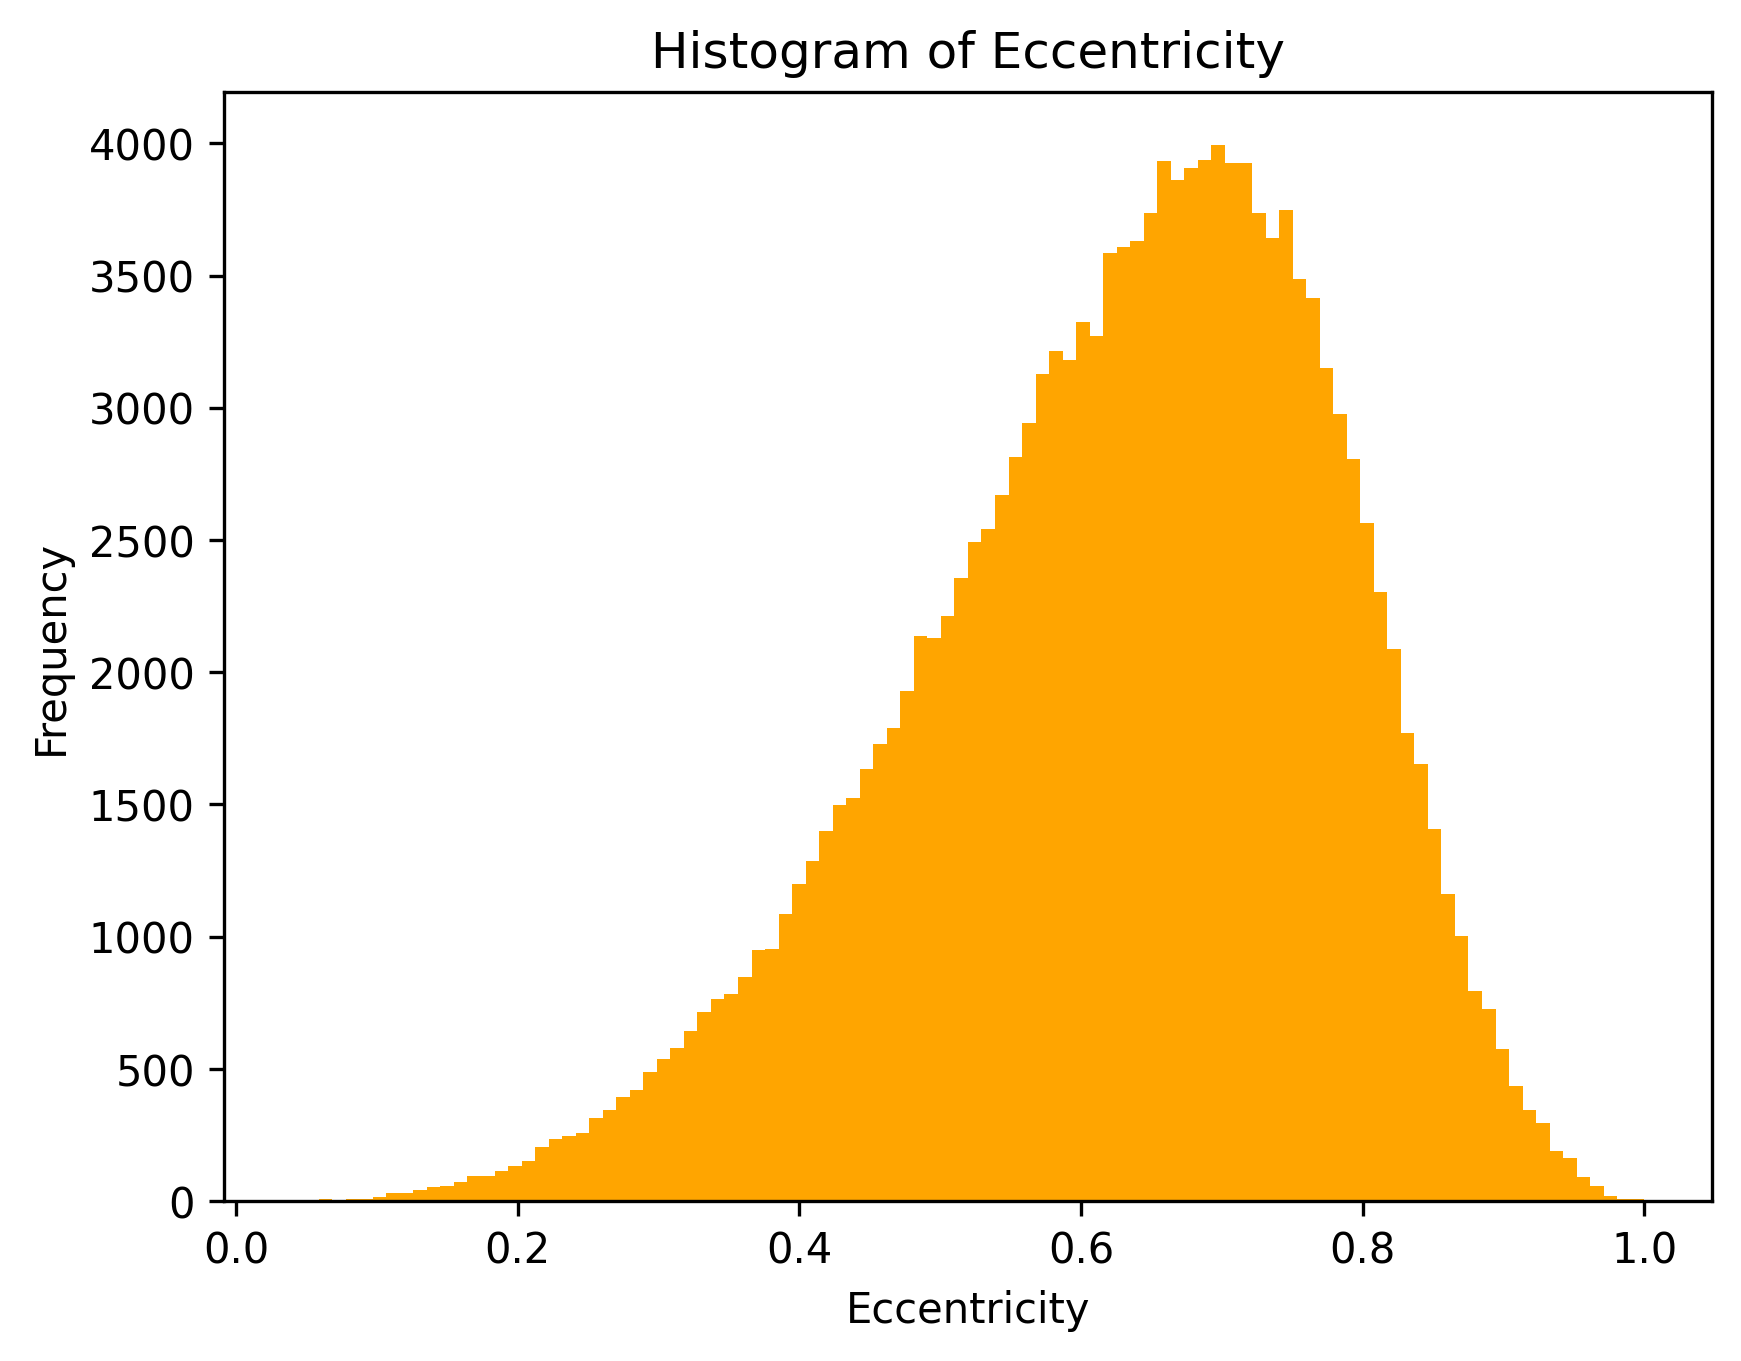

In [ ]:

feature_to_plot = 'Eccentricity'

plt.hist(features_df[feature_to_plot], color='orange', bins = 100)
plt.xlabel(feature_to_plot)
plt.title(f'Histogram of {feature_to_plot}')
plt.xlabel(feature_to_plot)
plt.ylabel('Frequency')

plt.show()


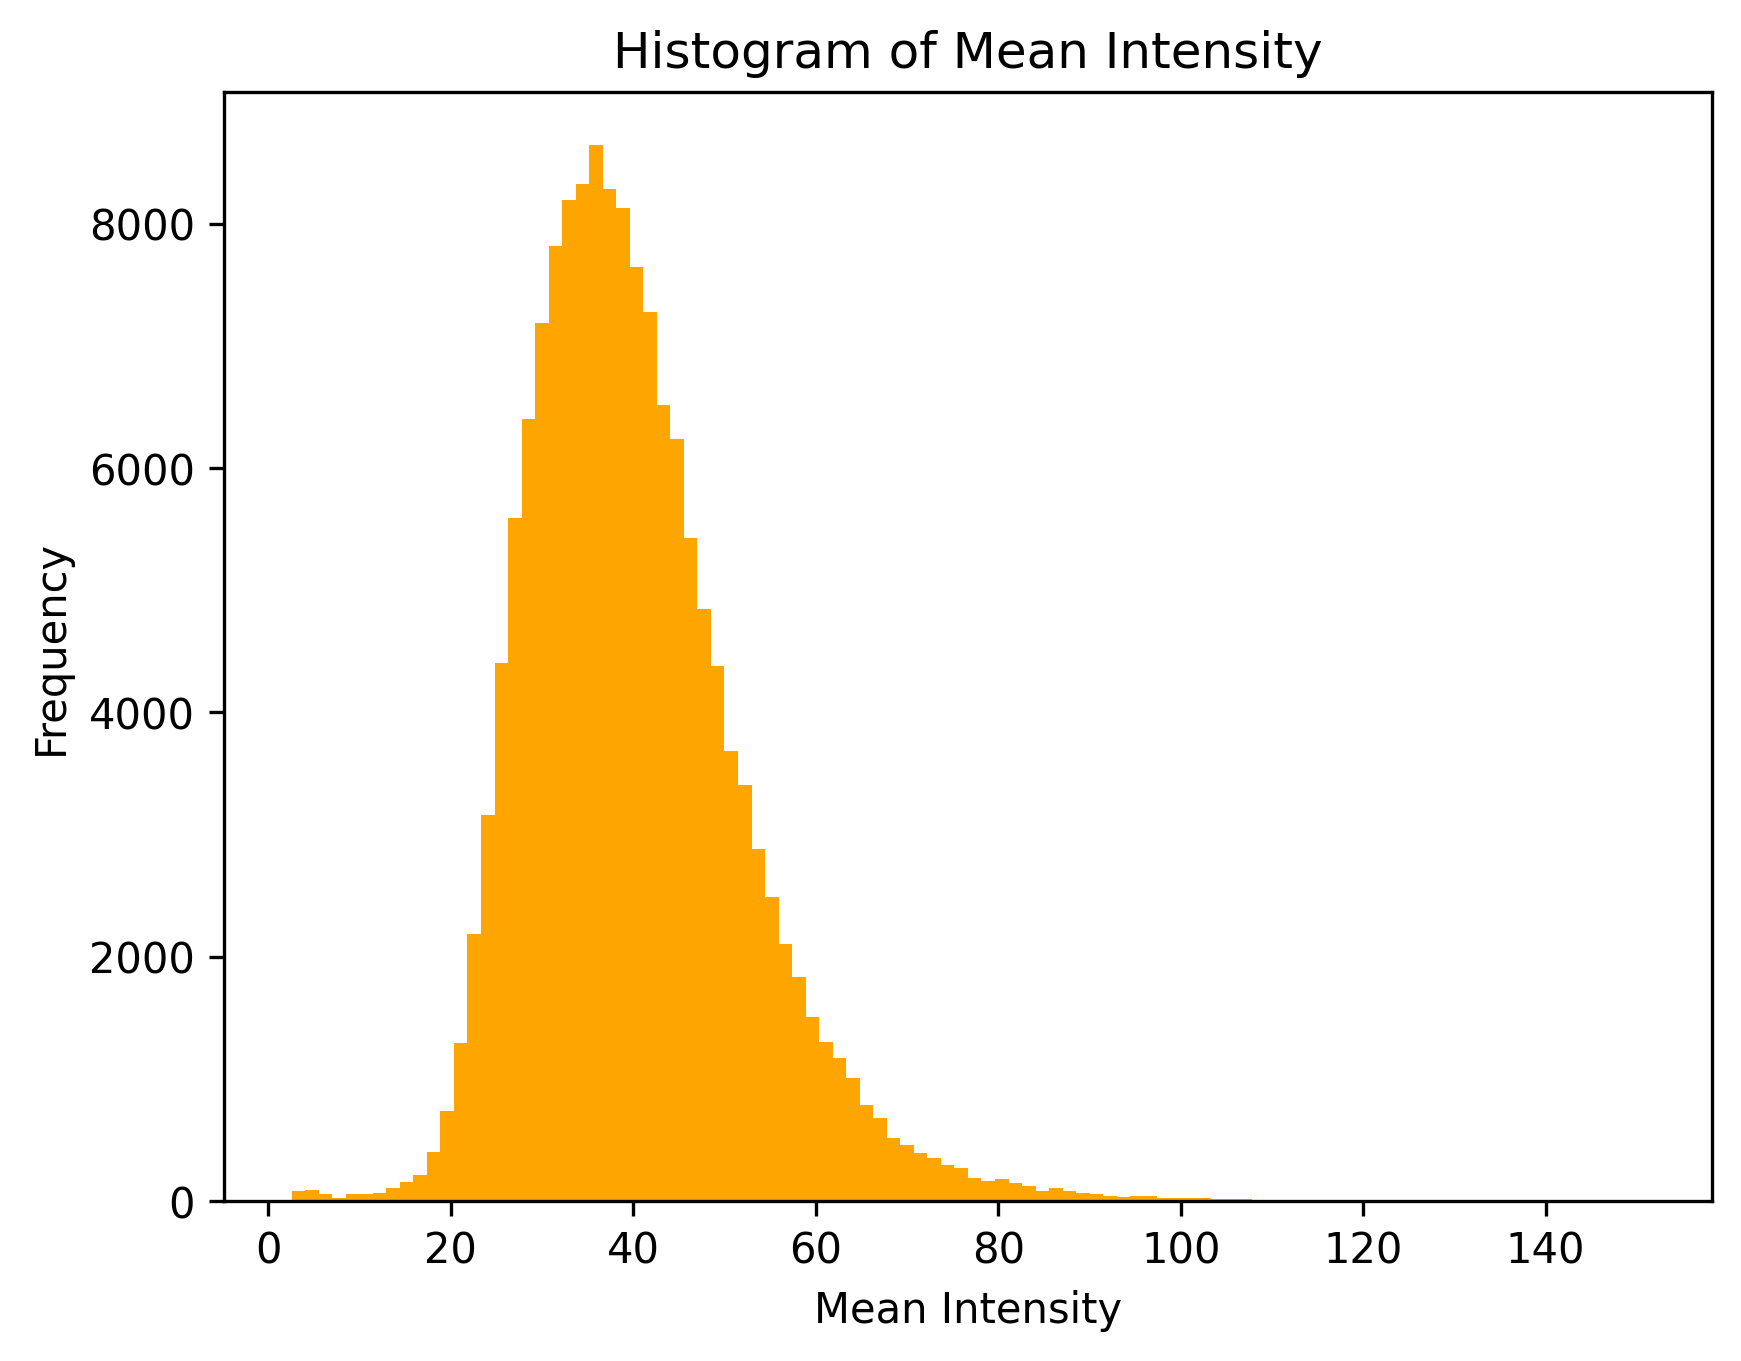

In [ ]:
#visualizing the features
feature_to_plot = 'Mean Intensity'

plt.hist(features_df[feature_to_plot], color='orange', bins = 100)
plt.xlabel(feature_to_plot)
plt.title(f'Histogram of {feature_to_plot}')
plt.xlabel(feature_to_plot)
plt.ylabel('Frequency')

plt.show()

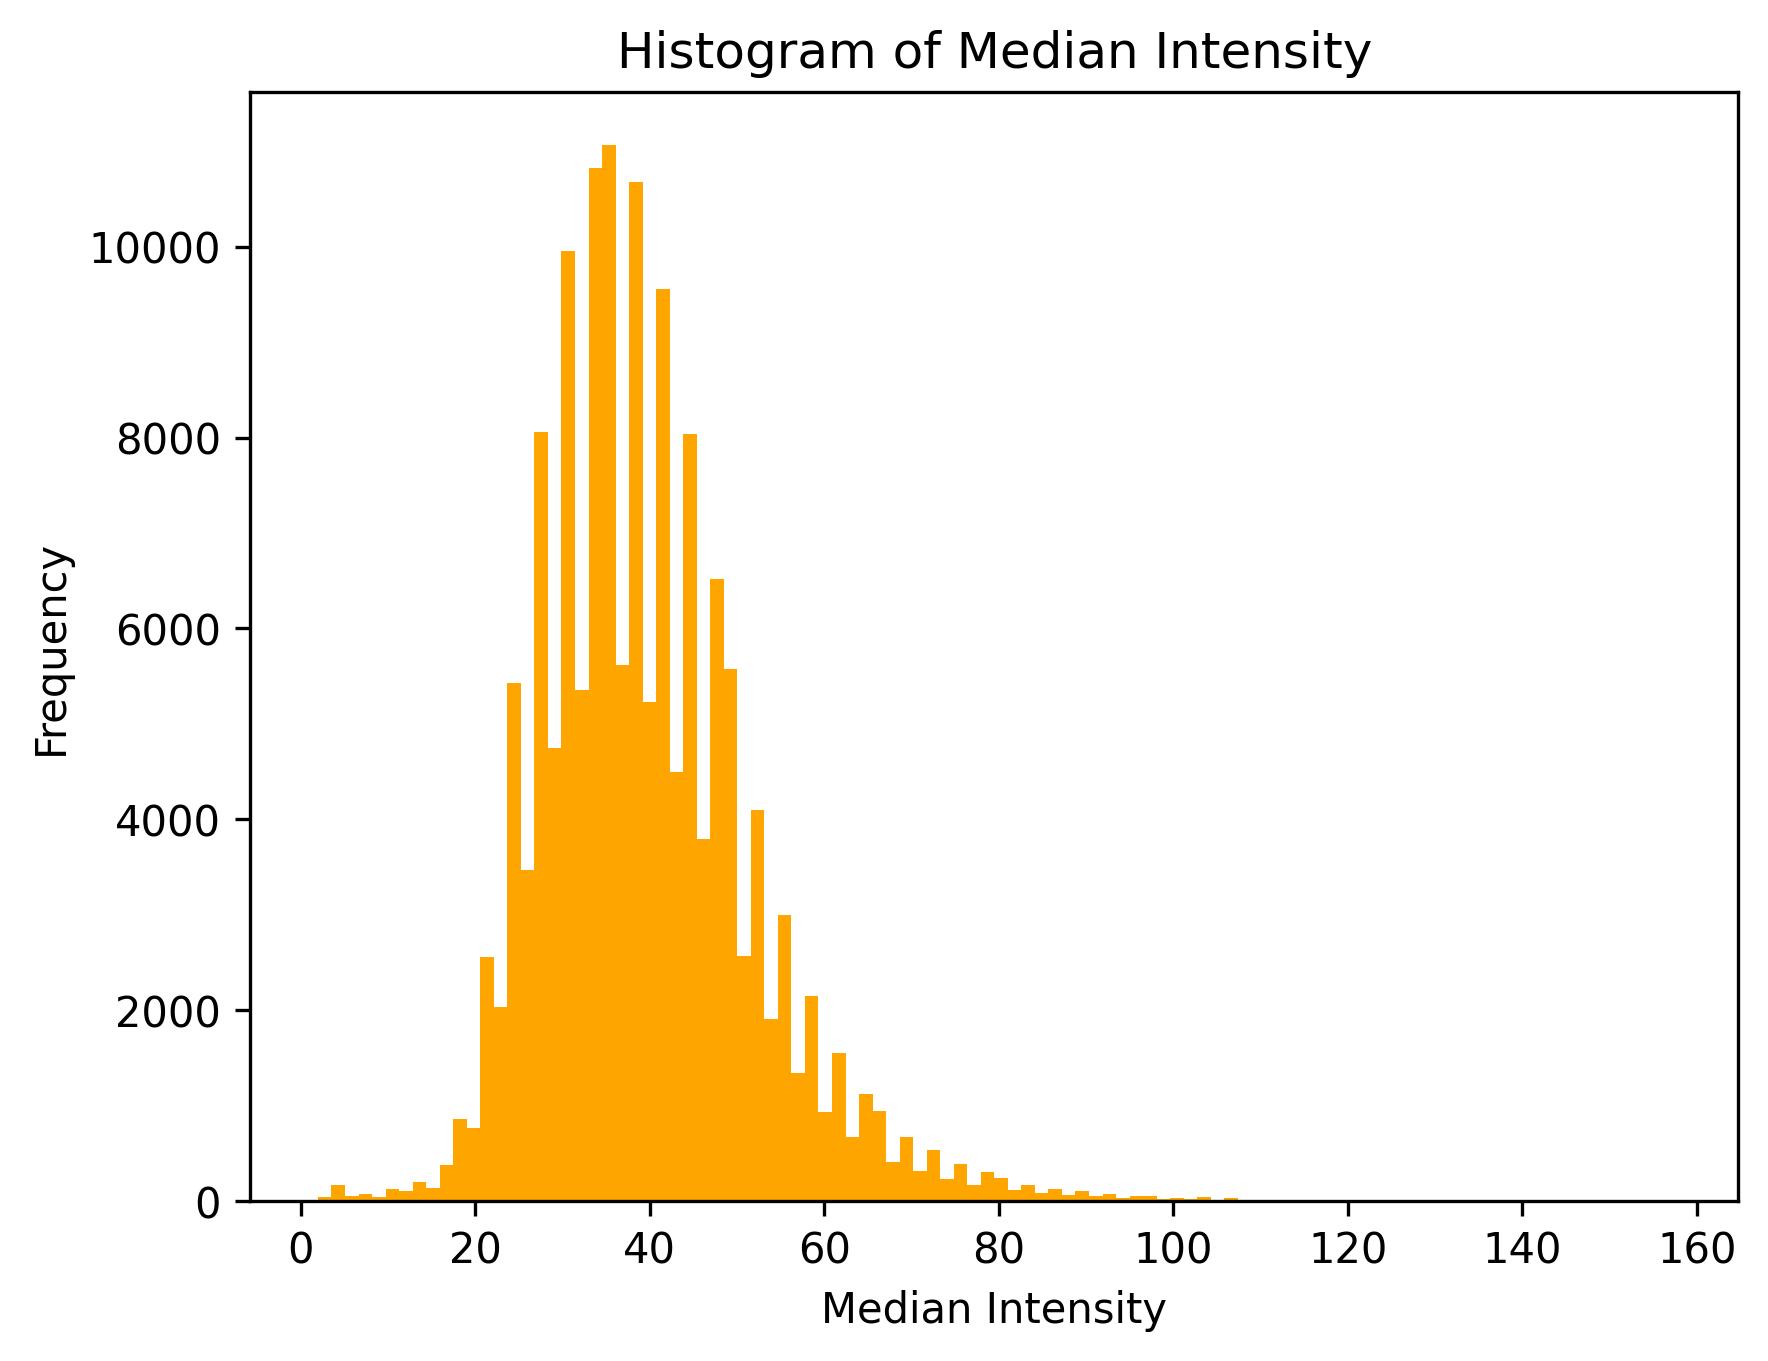

In [ ]:
feature_to_plot = 'Median Intensity'

plt.hist(features_df[feature_to_plot], color='orange', bins = 100)
plt.xlabel(feature_to_plot)
plt.title(f'Histogram of {feature_to_plot}')
plt.xlabel(feature_to_plot)
plt.ylabel('Frequency')

plt.show()

Matching metadata with the image/mask data:

In [ ]:
metadata_df = pd.read_csv(metadata_path)

NameError: name 'metadata_path' is not defined

In [ ]:
files = os.listdir('/content/drive/My Drive/P2/part2/Data/downsampled_data')

### Merging metadata with feature data

In [ ]:
import pandas as pd

metadata_df['relevant_identifier'] = metadata_df['FileName_OrigRNA'].str.split('-').str[0].str[:-3]


In [ ]:
print(metadata_df.head())

   Unnamed: 0                FileName_OrigRNA  Metadata_ChannelID  \
0           0  r01c01f01p01-ch3sk1fk1fl1.tiff                   5   
1           1  r01c01f02p01-ch3sk1fk1fl1.tiff                   5   
2           2  r01c01f03p01-ch3sk1fk1fl1.tiff                   5   
3           3  r01c01f04p01-ch3sk1fk1fl1.tiff                   5   
4           4  r01c01f05p01-ch3sk1fk1fl1.tiff                   5   

  Metadata_Plate Metadata_Well  Metadata_Site  Metadata_AbsPositionZ  \
0     BR00116991           A01              1               0.134679   
1     BR00116991           A01              2               0.134679   
2     BR00116991           A01              3               0.134673   
3     BR00116991           A01              4               0.134674   
4     BR00116991           A01              5               0.134681   

   Metadata_PositionX  Metadata_PositionY  Metadata_PositionZ  Metadata_Row  \
0           -0.000323            0.000323           -0.000002            

In [ ]:
features_df_path = '/content/drive/My Drive/Cellpose_Features.csv'
features_df = pd.read_csv(features_df_path)

features_df.head()

Area   Perimeter  Eccentricity  Solidity  Mean Intensity  \
0   274.0   71.284271      0.870736  0.964789       27.777372   
1   831.0  114.225397      0.762390  0.944318       42.832732   
2   573.0   95.290368      0.702246  0.908082       34.102967   
3   745.0  105.053824      0.672747  0.970052       41.405369   
4  1623.0  222.793939      0.966725  0.775813       34.433148   

   Median Intensity  Standard Deviation Intensity sample_name  
0              29.0                      9.553426   r05c18f05  
1              41.0                     18.227660   r05c18f05  
2              33.0                     17.138433   r05c18f05  
3              29.0                     30.832946   r05c18f05  
4              30.0                     22.060223   r05c18f05

In [ ]:
features_df['relevant_identifier'] = features_df['sample_name']

In [6]:
# merging features with metadata
merged_df = pd.merge(features_df, metadata_df, left_on='sample_name', right_on='relevant_identifier')  # Adjust 'metadata_column_name' to your actual metadata column

# save to CSV file
merged_df.to_csv('/content/drive/My Drive/Merged_Features_With_Metadata.csv', index=False)

print("Merged DataFrame shape:", merged_df.shape)

NameError: name 'features_df' is not defined

In [1]:
merged_df =pd.read_csv('/content/gdrive/My Drive/Merged_Features_With_Metadata.csv')

NameError: name 'pd' is not defined

In [8]:
merged_df['Metadata_pert_iname'].nunique() #number of chemical perturbations

250

In [12]:
merged_df.shape

(150759, 27)

In [ ]:
merged_df.columns #checking to make sure it works

Index(['Area', 'Perimeter', 'Eccentricity', 'Solidity', 'Mean Intensity',
       'Median Intensity', 'Standard Deviation Intensity', 'sample_name',
       'relevant_identifier_x', 'Unnamed: 0', 'FileName_OrigRNA',
       'Metadata_ChannelID', 'Metadata_Plate', 'Metadata_Well',
       'Metadata_Site', 'Metadata_AbsPositionZ', 'Metadata_PositionX',
       'Metadata_PositionY', 'Metadata_PositionZ', 'Metadata_Row',
       'Metadata_target', 'Metadata_experiment_type', 'Metadata_cell_line',
       'Metadata_pert_iname', 'Metadata_gene', 'Metadata_pubchem_cid',
       'relevant_identifier_y'],
      dtype='object')

Histogram of features by compound:

In [ ]:
compound_counts = merged_df.groupby('Metadata_pert_iname').size()
compound_counts.sort_values(ascending=False)

Metadata_pert_iname
DMSO           33848
BQ-788          1191
zamifenacin     1180
sacubitril      1146
M-25            1127
               ...  
GSK1070916       108
NVP-HSP990        86
AZ191             74
PF-431396         71
UNC2025           64
Length: 250, dtype: int64

In [ ]:
compound

In [ ]:
dmso_df = merged_df[merged_df['Metadata_pert_iname'] == 'DMSO']
bq_df = merged_df[merged_df['Metadata_pert_iname'] == 'BQ-788']

pf_df = merged_df[merged_df['Metadata_pert_iname'] == 'PF-431396']
unc_df = merged_df[merged_df['Metadata_pert_iname'] == 'UNC2025']

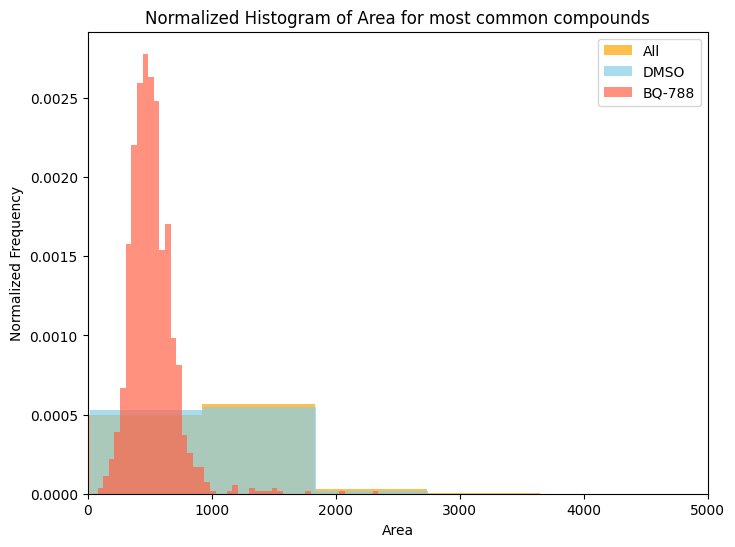

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(features_df['Area'], color='orange', bins = 50, alpha=0.7, label='All', density=True)

plt.hist(dmso_df['Area'], bins=50, color='skyblue', alpha=0.7, label='DMSO', density=True)
plt.hist(bq_df['Area'], bins=50, color='tomato', alpha=0.7, label='BQ-788', density=True)

plt.title('Normalized histogram of area for most common compounds')
plt.xlabel('Area')
plt.ylabel('Normalized Frequency')
plt.xlim(0, 5000)
plt.legend()

plt.show()


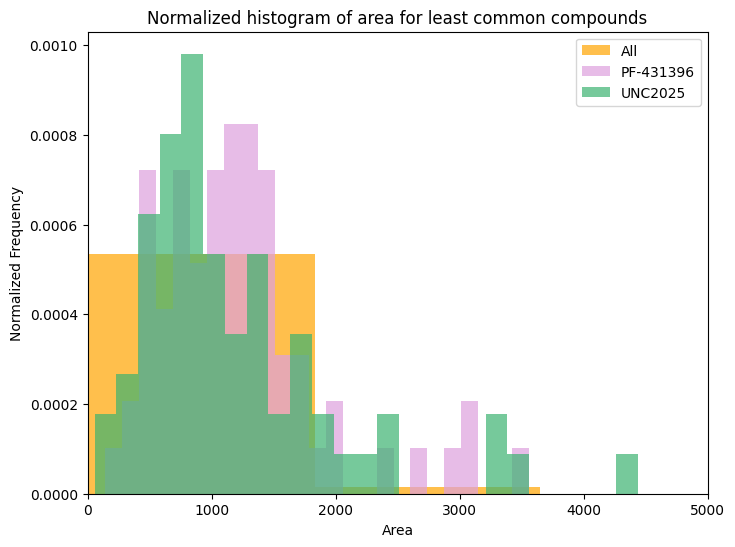

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(features_df['Area'], color='orange', bins = 25, alpha=0.7, label='All', density=True)

plt.hist(pf_df['Area'], bins=25, color='plum', alpha=0.7, label='PF-431396', density=True)
plt.hist(unc_df['Area'], bins=25, color='mediumseagreen', alpha=0.7, label='UNC2025', density=True)

plt.title('Normalized histogram of area for least common compounds')
plt.xlabel('Area')
plt.ylabel('Normalized Frequency')
plt.xlim(0, 5000)
plt.legend()

plt.show()

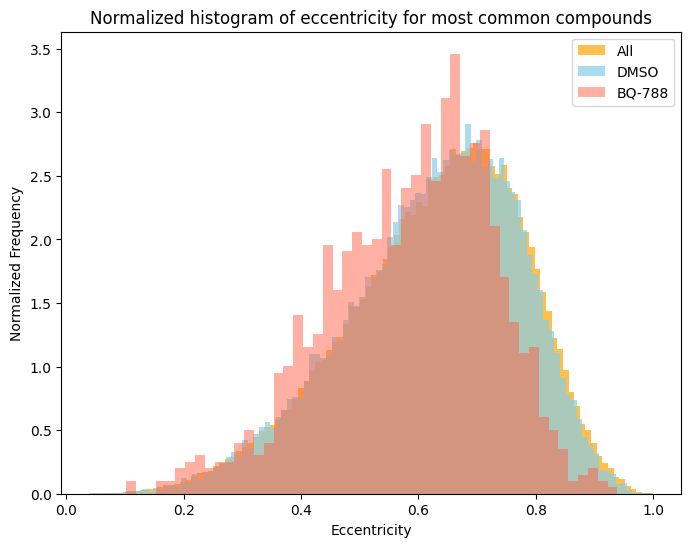

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(features_df['Eccentricity'], color='orange', bins = 100, alpha=0.7, label='All', density=True)
plt.hist(dmso_df['Eccentricity'], bins=100, color='skyblue', alpha=0.7, label='DMSO', density=True)
plt.hist(bq_df['Eccentricity'], bins=50, color='tomato', alpha=0.5, label='BQ-788', density=True)

plt.title('Normalized histogram of eccentricity for most common compounds')
plt.xlabel('Eccentricity')
plt.ylabel('Normalized Frequency')
plt.legend()

plt.show()


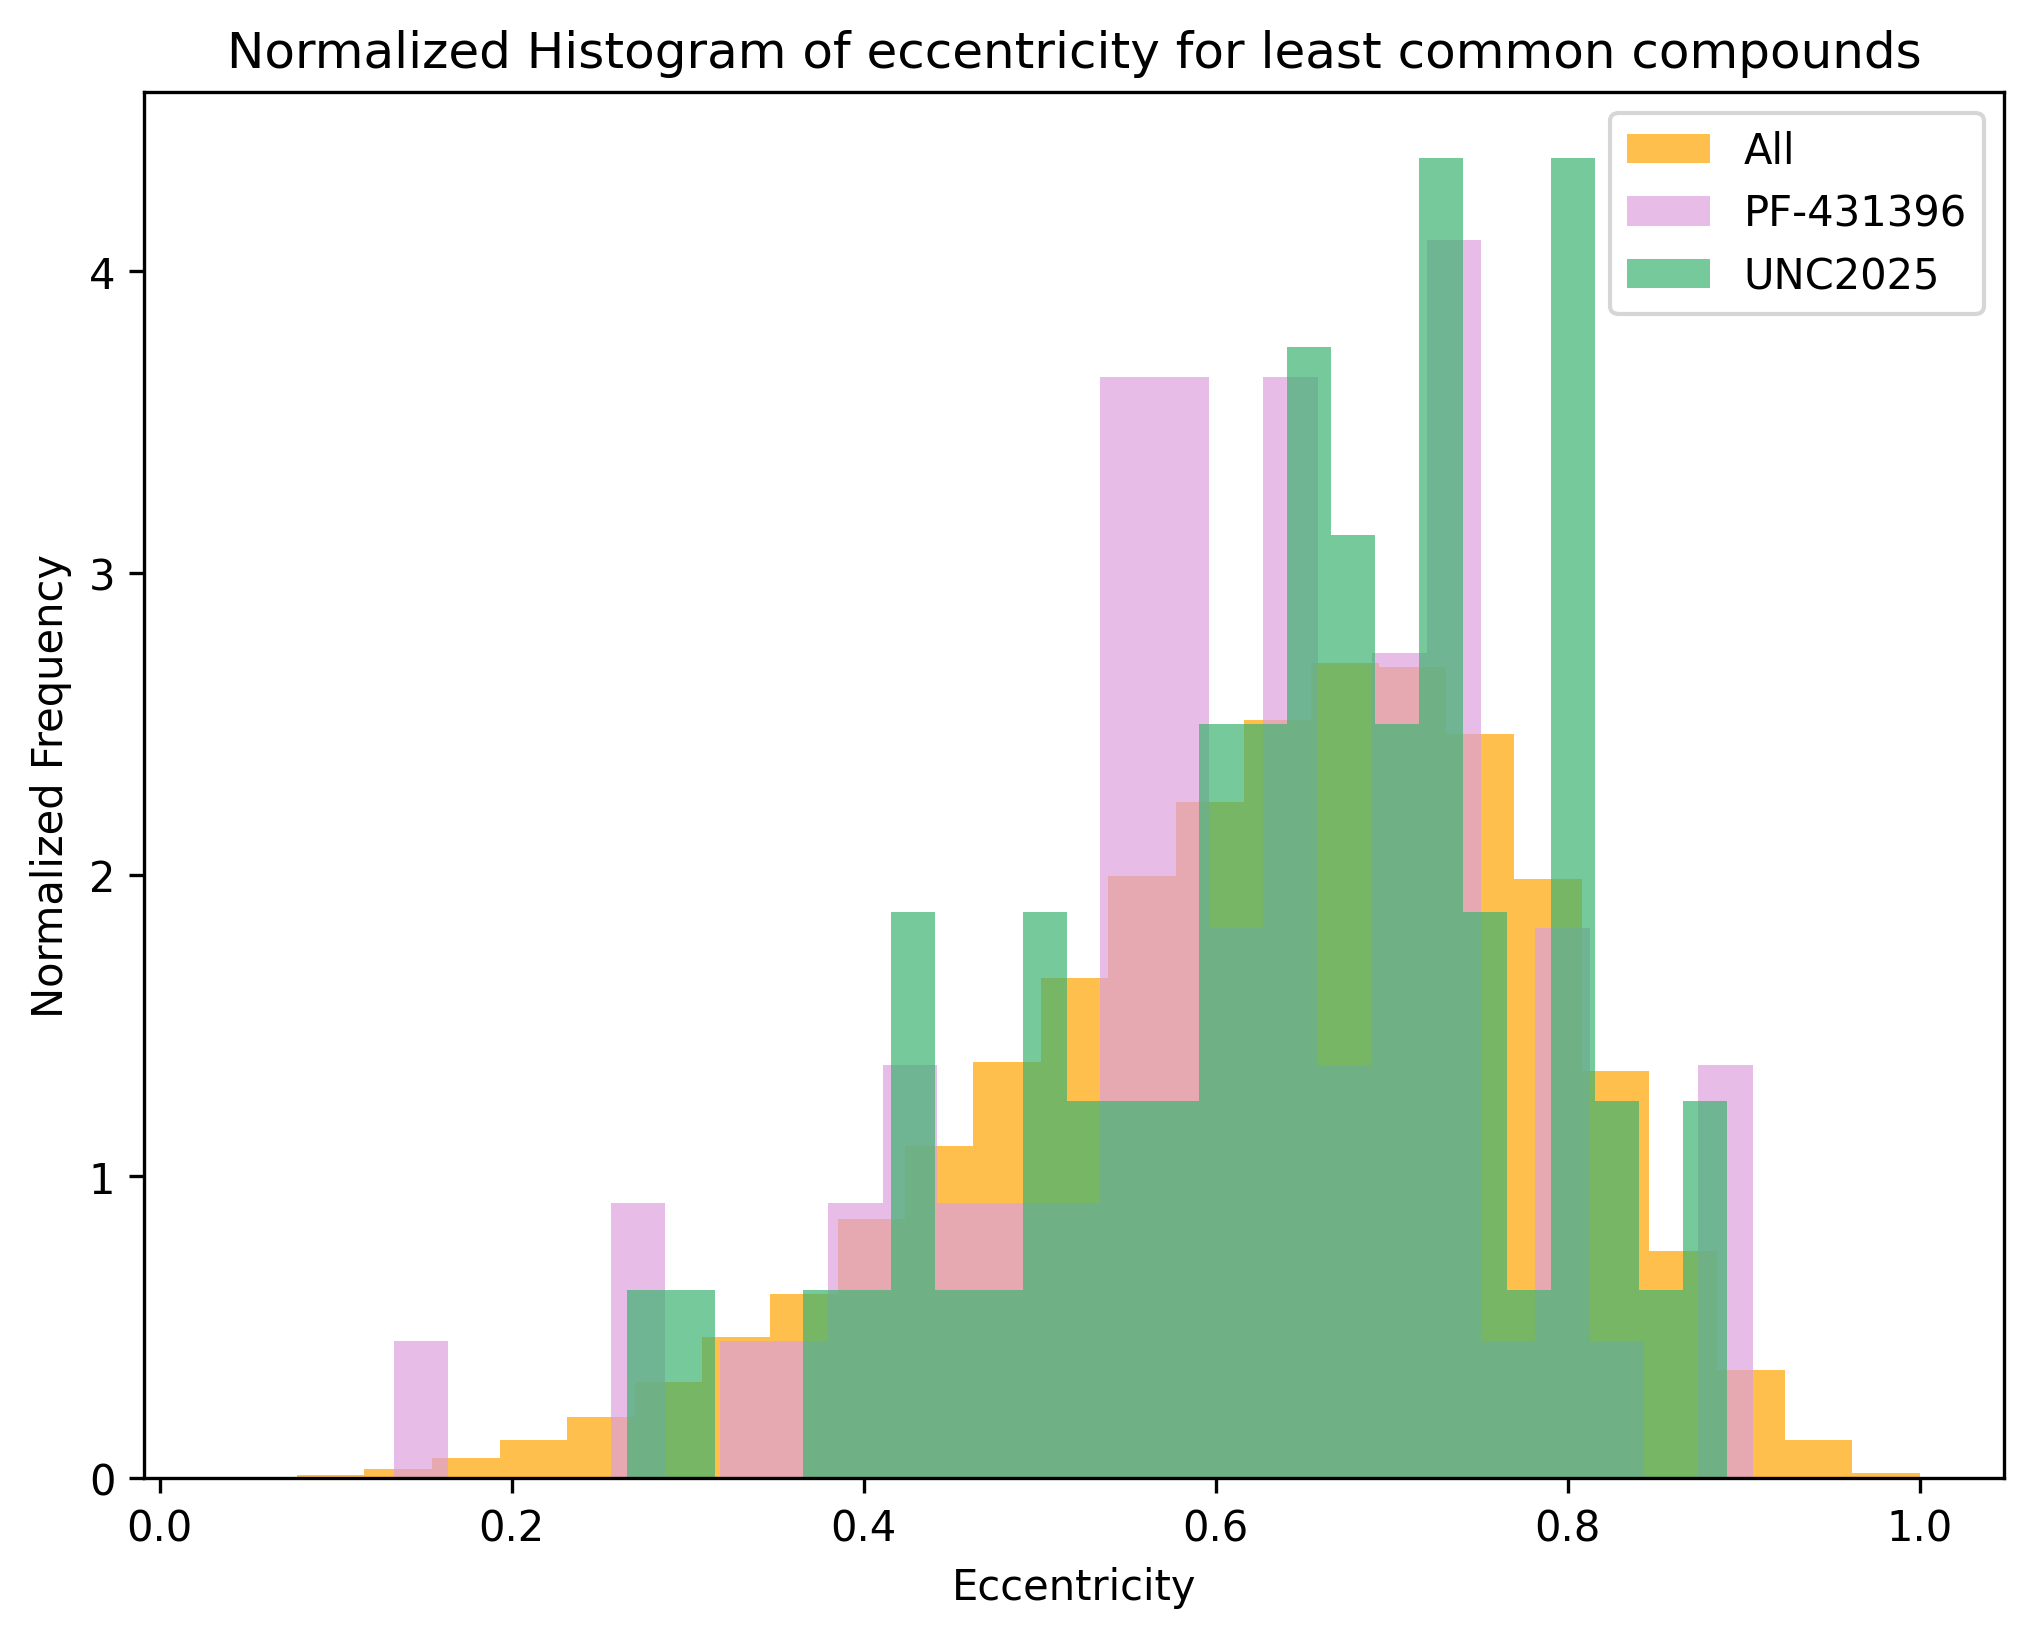

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(features_df['Eccentricity'], color='orange', bins = 25, alpha=0.7, label='All', density=True)

plt.hist(pf_df['Eccentricity'], bins=25, color='plum', alpha=0.7, label='PF-431396', density=True)
plt.hist(unc_df['Eccentricity'], bins=25, color='mediumseagreen', alpha=0.7, label='UNC2025', density=True)

plt.title('Normalized Histogram of eccentricity for least common compounds')
plt.xlabel('Eccentricity')
plt.ylabel('Normalized Frequency')
plt.legend()

plt.show()

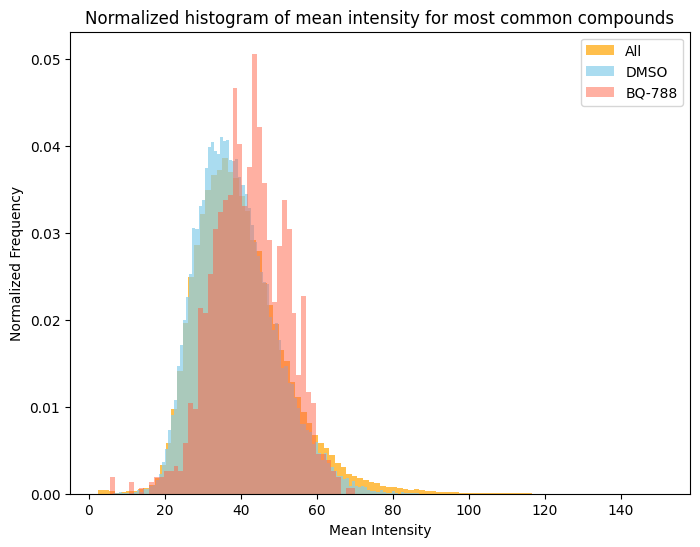

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(features_df['Mean Intensity'], color='orange', bins = 100, alpha=0.7, label='All', density=True)
plt.hist(dmso_df['Mean Intensity'], bins=100, color='skyblue', alpha=0.7, label='DMSO', density=True)
plt.hist(bq_df['Mean Intensity'], bins=50, color='tomato', alpha=0.5, label='BQ-788', density=True)

plt.title('Normalized histogram of mean intensity for most common compounds')
plt.xlabel('Mean Intensity')
plt.ylabel('Normalized Frequency')
plt.legend()

plt.show()

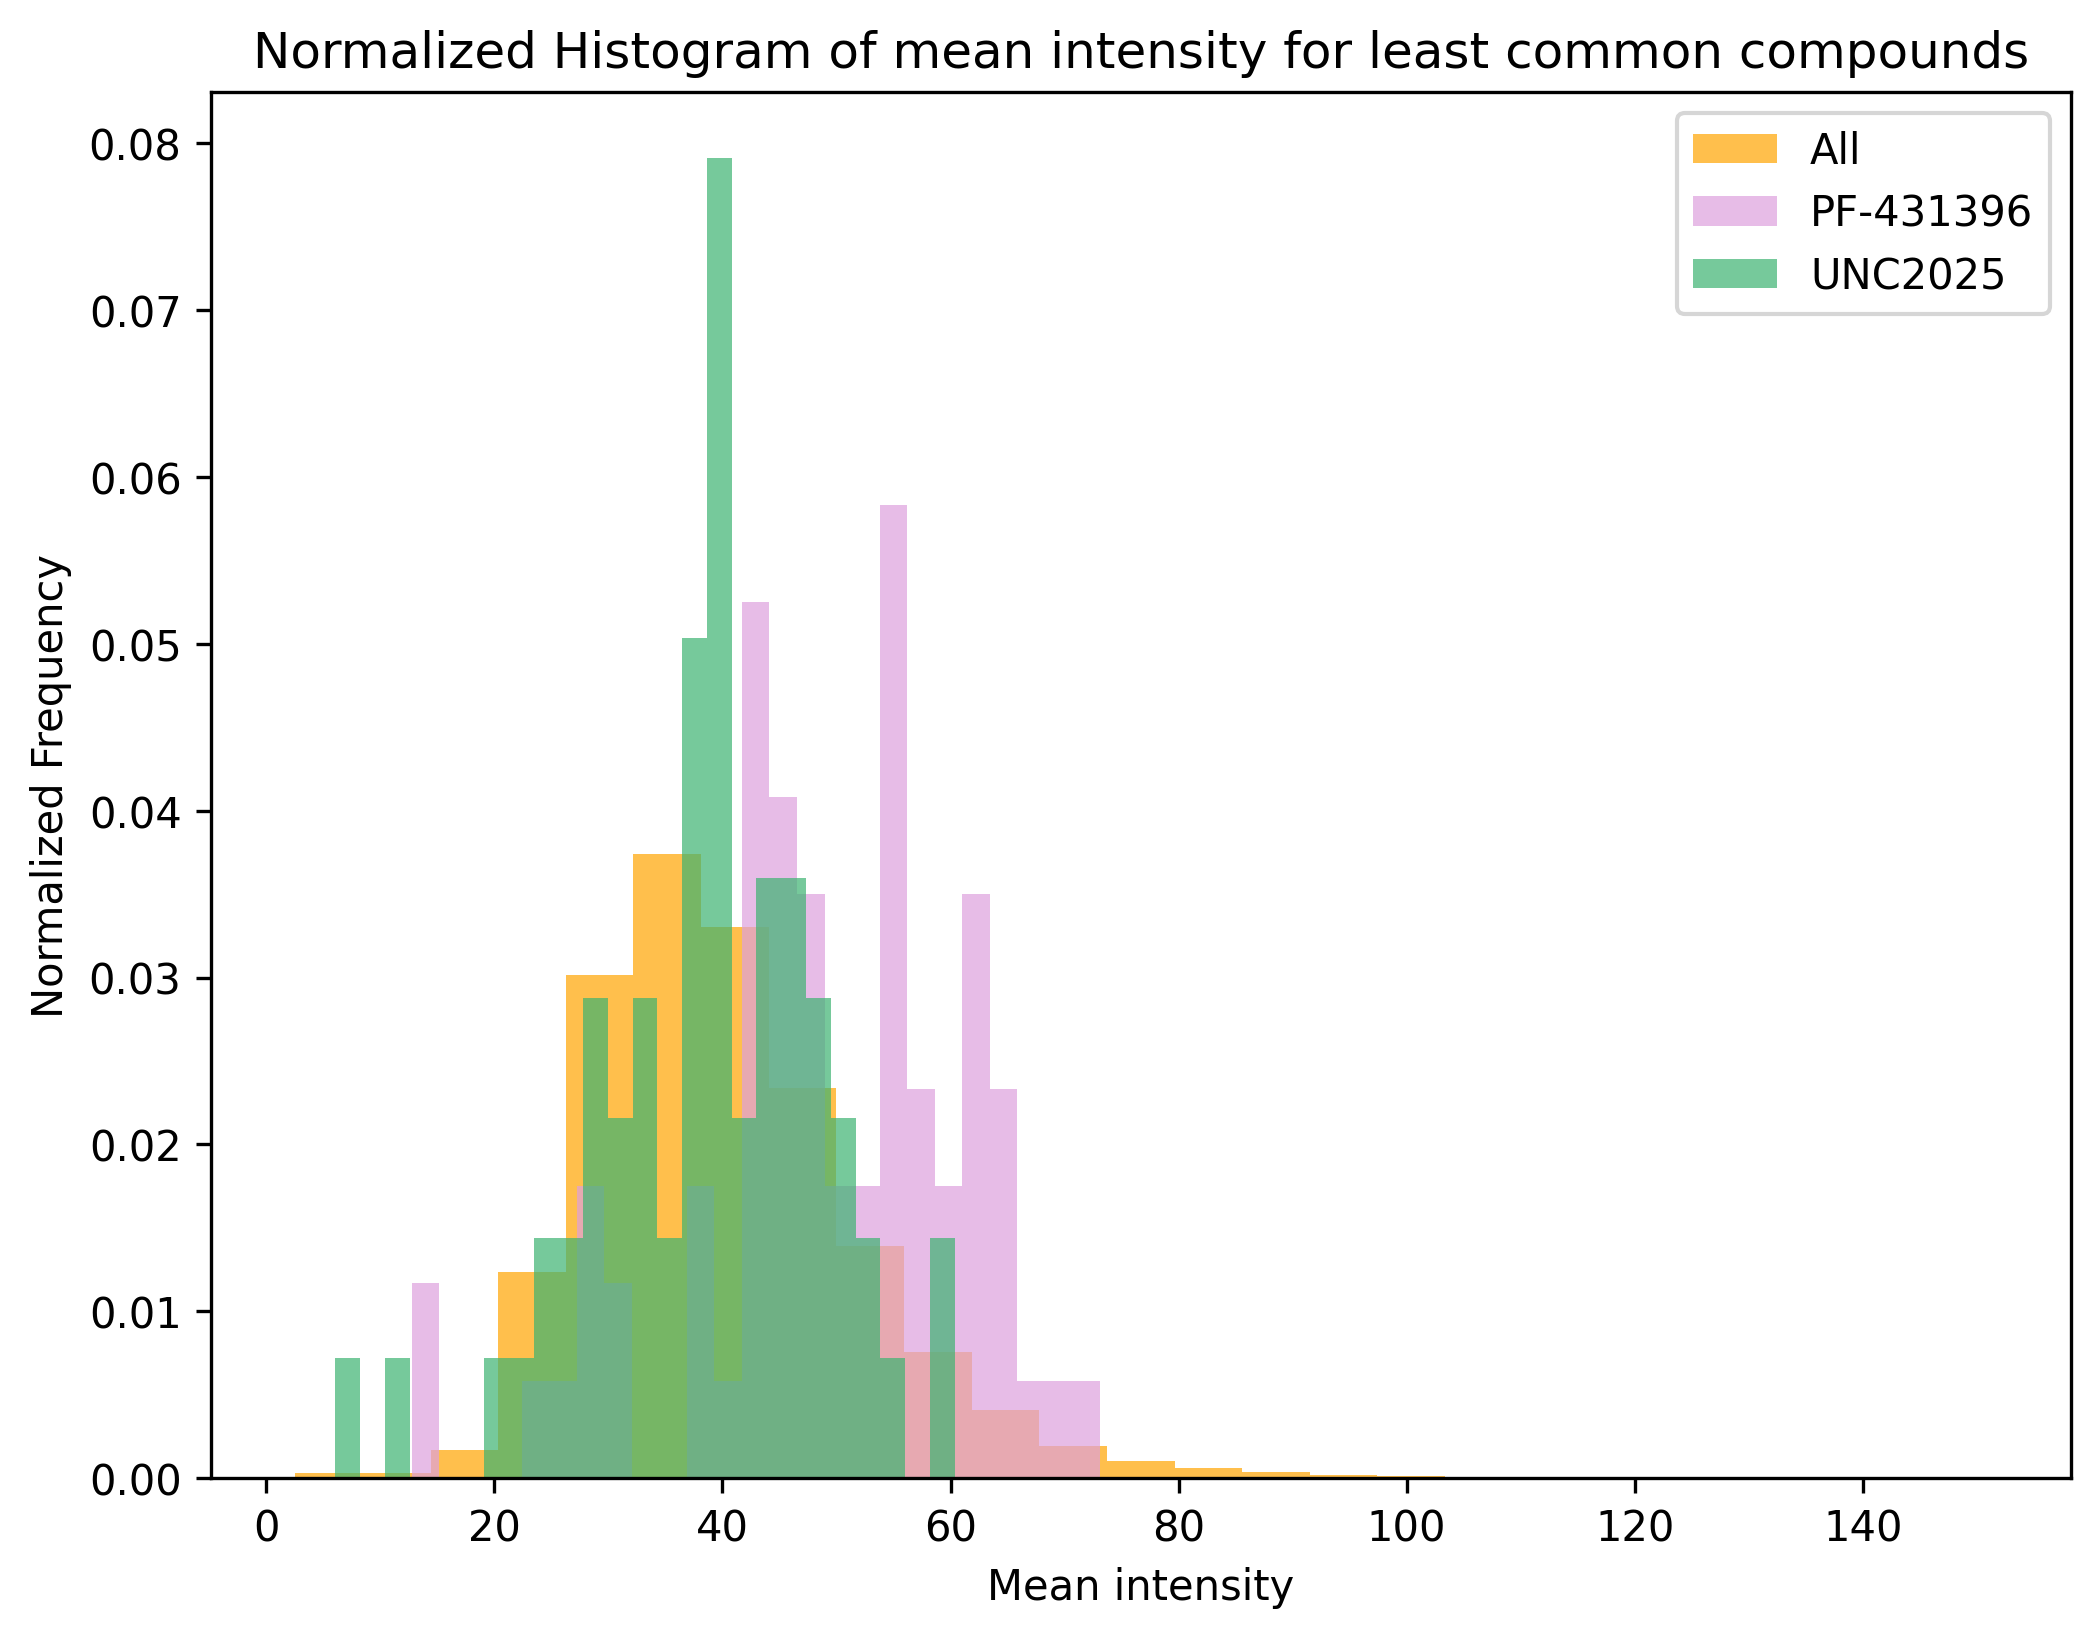

In [ ]:

plt.figure(figsize=(8, 6))
plt.hist(features_df['Mean Intensity'], color='orange', bins = 25, alpha=0.7, label='All', density=True)

plt.hist(pf_df['Mean Intensity'], bins=25, color='plum', alpha=0.7, label='PF-431396', density=True)
plt.hist(unc_df['Mean Intensity'], bins=25, color='mediumseagreen', alpha=0.7, label='UNC2025', density=True)

plt.title('Normalized Histogram of mean intensity for least common compounds')
plt.xlabel('Mean intensity')
plt.ylabel('Normalized Frequency')
plt.legend()

plt.show()

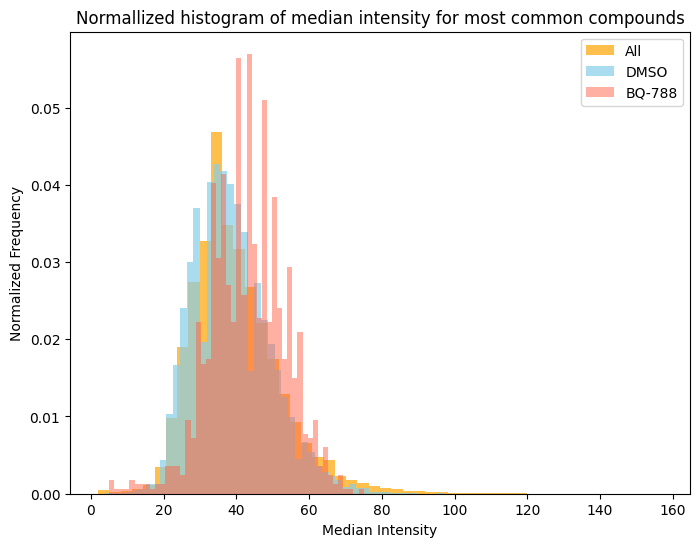

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(features_df['Median Intensity'], color='orange', bins = 50, alpha=0.7, label='All', density=True)
plt.hist(dmso_df['Median Intensity'], bins=50, color='skyblue', alpha=0.7, label='DMSO', density=True)
plt.hist(bq_df['Median Intensity'], bins=50, color='tomato', alpha=0.5, label='BQ-788', density=True)

plt.title('Normallized histogram of median intensity for most common compounds')
plt.xlabel('Median Intensity')
plt.ylabel('Normalized Frequency')
plt.legend()

plt.show()

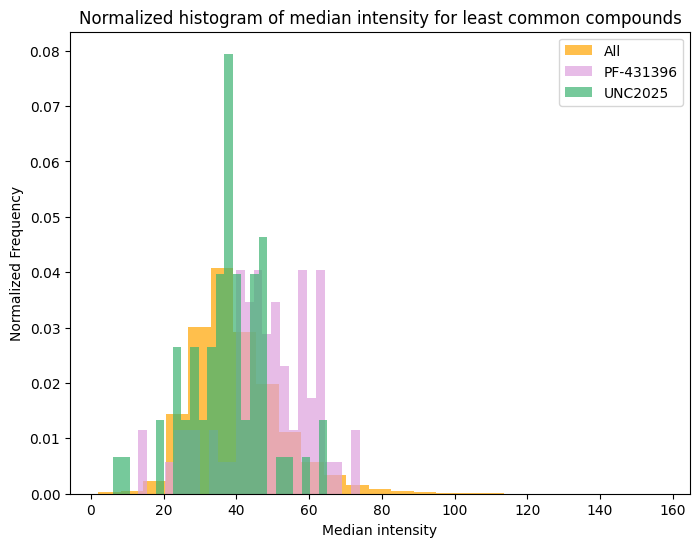

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(features_df['Median Intensity'], color='orange', bins = 25, alpha=0.7, label='All', density=True)

plt.hist(pf_df['Median Intensity'], bins=25, color='plum', alpha=0.7, label='PF-431396', density=True)
plt.hist(unc_df['Median Intensity'], bins=25, color='mediumseagreen', alpha=0.7, label='UNC2025', density=True)

plt.title('Normalized histogram of median intensity for least common compounds')
plt.xlabel('Median intensity')
plt.ylabel('Normalized Frequency')
plt.legend()

plt.show()

### Splitting into training and testing

First, I choose my features for training, and then my target feature, which is the chemical perturbation feature.

In [ ]:
features = merged_df[['Area', 'Perimeter', 'Eccentricity', 'Solidity', 'Mean Intensity',
       'Median Intensity', 'Standard Deviation Intensity']]
target = merged_df['Metadata_pert_iname']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

Random forest classifier

In [ ]:
# Initialize Random Forest
rf_model = RandomForestClassifier(n_estimators=100)

# Train the model
rf_model.fit(X_train, y_train)


RandomForestClassifier()

Evaluation metrics

In [ ]:

# Predictions
y_pred = rf_model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.219620589015654


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                                         precision    recall  f1-score   support

                              1-octanol       0.00      0.00      0.00        75
                    2,5-furandimethanol       0.00      0.00      0.00        99
                       2-Oleoylglycerol       0.00      0.00      0.00       115
                                 4-CMTB       0.00      0.00      0.00       197
                      4-methylhistamine       0.00      0.00      0.00       152
                 7-hydroxystaurosporine       0.00      0.00      0.00        21
                                A205804       0.06      0.01      0.02       210
                                 AC-710       0.03      0.01      0.02       170
                                   AK-7       0.00      0.00      0.00        70
                                 ANR-94       0.00      0.00      0.00        81
                                  AR-12       0.11      0.06      0.07        18
                           

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.219620589015654

These are the feature importances: array([0.14403355, 0.14339724, 0.15208332, 0.15129627, 0.1513849 ,
       0.10095896, 0.15684575])

In [ ]:
rf_model.feature_importances_ # Access feature importances from the model object

array([0.14403355, 0.14339724, 0.15208332, 0.15129627, 0.1513849 ,
       0.10095896, 0.15684575])

### Support vector machine

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd


In [ ]:
features = ['Area', 'Perimeter', 'Eccentricity', 'Solidity', 'Mean Intensity',
       'Median Intensity', 'Standard Deviation Intensity']
# Define the target variable (compound or perturbation name)
X = merged_df[features]  # Features
y = merged_df['Metadata_pert_iname']  # Target


# Step 3: Train the SVM model
svm_model = SVC()  # You can also try different kernels, like 'rbf' or 'poly'
svm_model.fit(X_train, y_train)

# Step 4: Make predictions on the test set
y_pred = svm_model.predict(X_test)

# Step 5: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.22456221809498542

Classification Report:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                                         precision    recall  f1-score   support

                              1-octanol       0.00      0.00      0.00        92
                    2,5-furandimethanol       0.00      0.00      0.00       100
                       2-Oleoylglycerol       0.00      0.00      0.00       138
                                 4-CMTB       0.00      0.00      0.00       182
                      4-methylhistamine       0.00      0.00      0.00       134
                 7-hydroxystaurosporine       0.00      0.00      0.00        31
                                A205804       0.00      0.00      0.00       215
                                 AC-710       0.00      0.00      0.00       149
                                   AK-7       0.00      0.00      0.00        80
                                 ANR-94       0.00      0.00      0.00        97
                                  AR-12       0.00      0.00      0.00        24
                           

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
features = ['Area', 'Perimeter', 'Eccentricity', 'Solidity', 'Mean Intensity',
       'Median Intensity', 'Standard Deviation Intensity']

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
X = merged_df[features]  # Features
y = merged_df['Metadata_pert_iname']  # Target

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both the train and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the SVM model with RBF kernel on scaled data
svm_model = SVC(kernel='rbf')
svm_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.23355001326611832

Classification Report:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                                         precision    recall  f1-score   support

                              1-octanol       0.00      0.00      0.00        75
                    2,5-furandimethanol       0.00      0.00      0.00        89
                       2-Oleoylglycerol       0.00      0.00      0.00       131
                                 4-CMTB       0.00      0.00      0.00       226
                      4-methylhistamine       0.00      0.00      0.00       175
                 7-hydroxystaurosporine       0.00      0.00      0.00        22
                                A205804       0.00      0.00      0.00       212
                                 AC-710       0.11      0.03      0.05       165
                                   AK-7       0.00      0.00      0.00        91
                                 ANR-94       0.00      0.00      0.00        93
                                  AR-12       0.00      0.00      0.00        31
                           